In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# === MOUNT GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
DATASET_PATH = "/content/drive/My Drive/dogs_n_cats"

# Define parameters
IMG_SIZE = (150, 150)  # Resize images
BATCH_SIZE = 32        # Number of images per batch
SEED = 42              # For reproducibility

# Define ImageDataGenerator with a 30% split for validation+test, with augmentation for training
train_data_gen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Rotate up to 20 degrees
    width_shift_range=0.2,       # Shift width by up to 20%
    height_shift_range=0.2,      # Shift height by up to 20%
    horizontal_flip=True,        # Randomly flip horizontally
    zoom_range=0.2,              # Zoom in/out by up to 20%
    brightness_range=[0.8, 1.2], # Adjust brightness between 80% and 120%
    validation_split=0.30        # 30% for validation+test
)

# Training Set (70% of total dataset)
train_generator = train_data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',    # Use 'binary' if only 2 classes
    subset='training',           # 70% of total data
    seed=SEED,
    shuffle=True
)

# Define ImageDataGenerator for validation+test split (no augmentation, 50% split of the 30%)
val_test_data_gen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    validation_split=0.50        # 50% split of the remaining 30%
)

# Validation Set (15% of total dataset)
val_generator = val_test_data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',    # Use 'binary' if only 2 classes
    subset='training',           # 50% of the 30% -> 15% of total
    seed=SEED,
    shuffle=True
)

# Test Set (15% of total dataset)
test_generator = val_test_data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',    # Use 'binary' if only 2 classes
    subset='validation',         # 50% of the 30% -> 15% of total
    seed=SEED,
    shuffle=True
)

# Print class names
print("Classes:", list(train_generator.class_indices.keys()))

# Optional: Verify a batch from each generator
images, labels = next(train_generator)
print(f"Training batch shape: {images.shape}")  # e.g., (32, 150, 150, 3)
print(f"Training labels shape: {labels.shape}") # e.g., (32, num_classes)

images, labels = next(val_generator)
print(f"Validation batch shape: {images.shape}")
print(f"Validation labels shape: {labels.shape}")

images, labels = next(test_generator)
print(f"Test batch shape: {images.shape}")
print(f"Test labels shape: {labels.shape}")

Mounted at /content/drive
Found 700 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Classes: ['cats_set', 'dogs_set']
Training batch shape: (32, 150, 150, 3)
Training labels shape: (32,)
Validation batch shape: (32, 150, 150, 3)
Validation labels shape: (32,)
Test batch shape: (32, 150, 150, 3)
Test labels shape: (32,)


In [3]:
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model (don't train ResNet layers initially)
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,                    # Pre-trained ResNet50
    GlobalAveragePooling2D(),      # Reduce spatial dimensions (instead of Flatten)
    Dense(128, activation='relu'), # Fully connected layer
    Dropout(0.5),                  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer
])


# Unfreeze the last few layers of ResNet50 for fine-tuning
#for layer in base_model.layers[-10:]:  # Unfreezing the last 10 layers
#    layer.trainable = True

# Compile the model with a lower learning rate
#fine_tune_lr = 1e-5  # 1/10th of the previous learning rate
#model.compile(optimizer=Adam(learning_rate=fine_tune_lr), loss='binary_crossentropy', metrics=['accuracy'])...

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 211s 9s/step - accuracy: 0.4775 - loss: 0.8079 - val_accuracy: 0.5060 - val_loss: 0.6933
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.5228 - loss: 0.7192 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 435ms/step - accuracy: 0.5009 - loss: 0.7080 - val_accuracy: 0.5720 - val_loss: 0.6834
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - accuracy: 0.5131 - loss: 0.6985 - val_accuracy: 0.5080 - val_loss: 0.6866
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.4830 - loss: 0.7011 - val_accuracy: 0.5160 - val_loss: 0.6864


In [5]:
# Evaluate on test set
test_generator.reset()
test_steps = test_generator.samples // BATCH_SIZE
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.5153 - loss: 0.6835
Test Accuracy: 51.04%


Filters shape for layer 0 (conv1_conv): (7, 7, 3, 64)


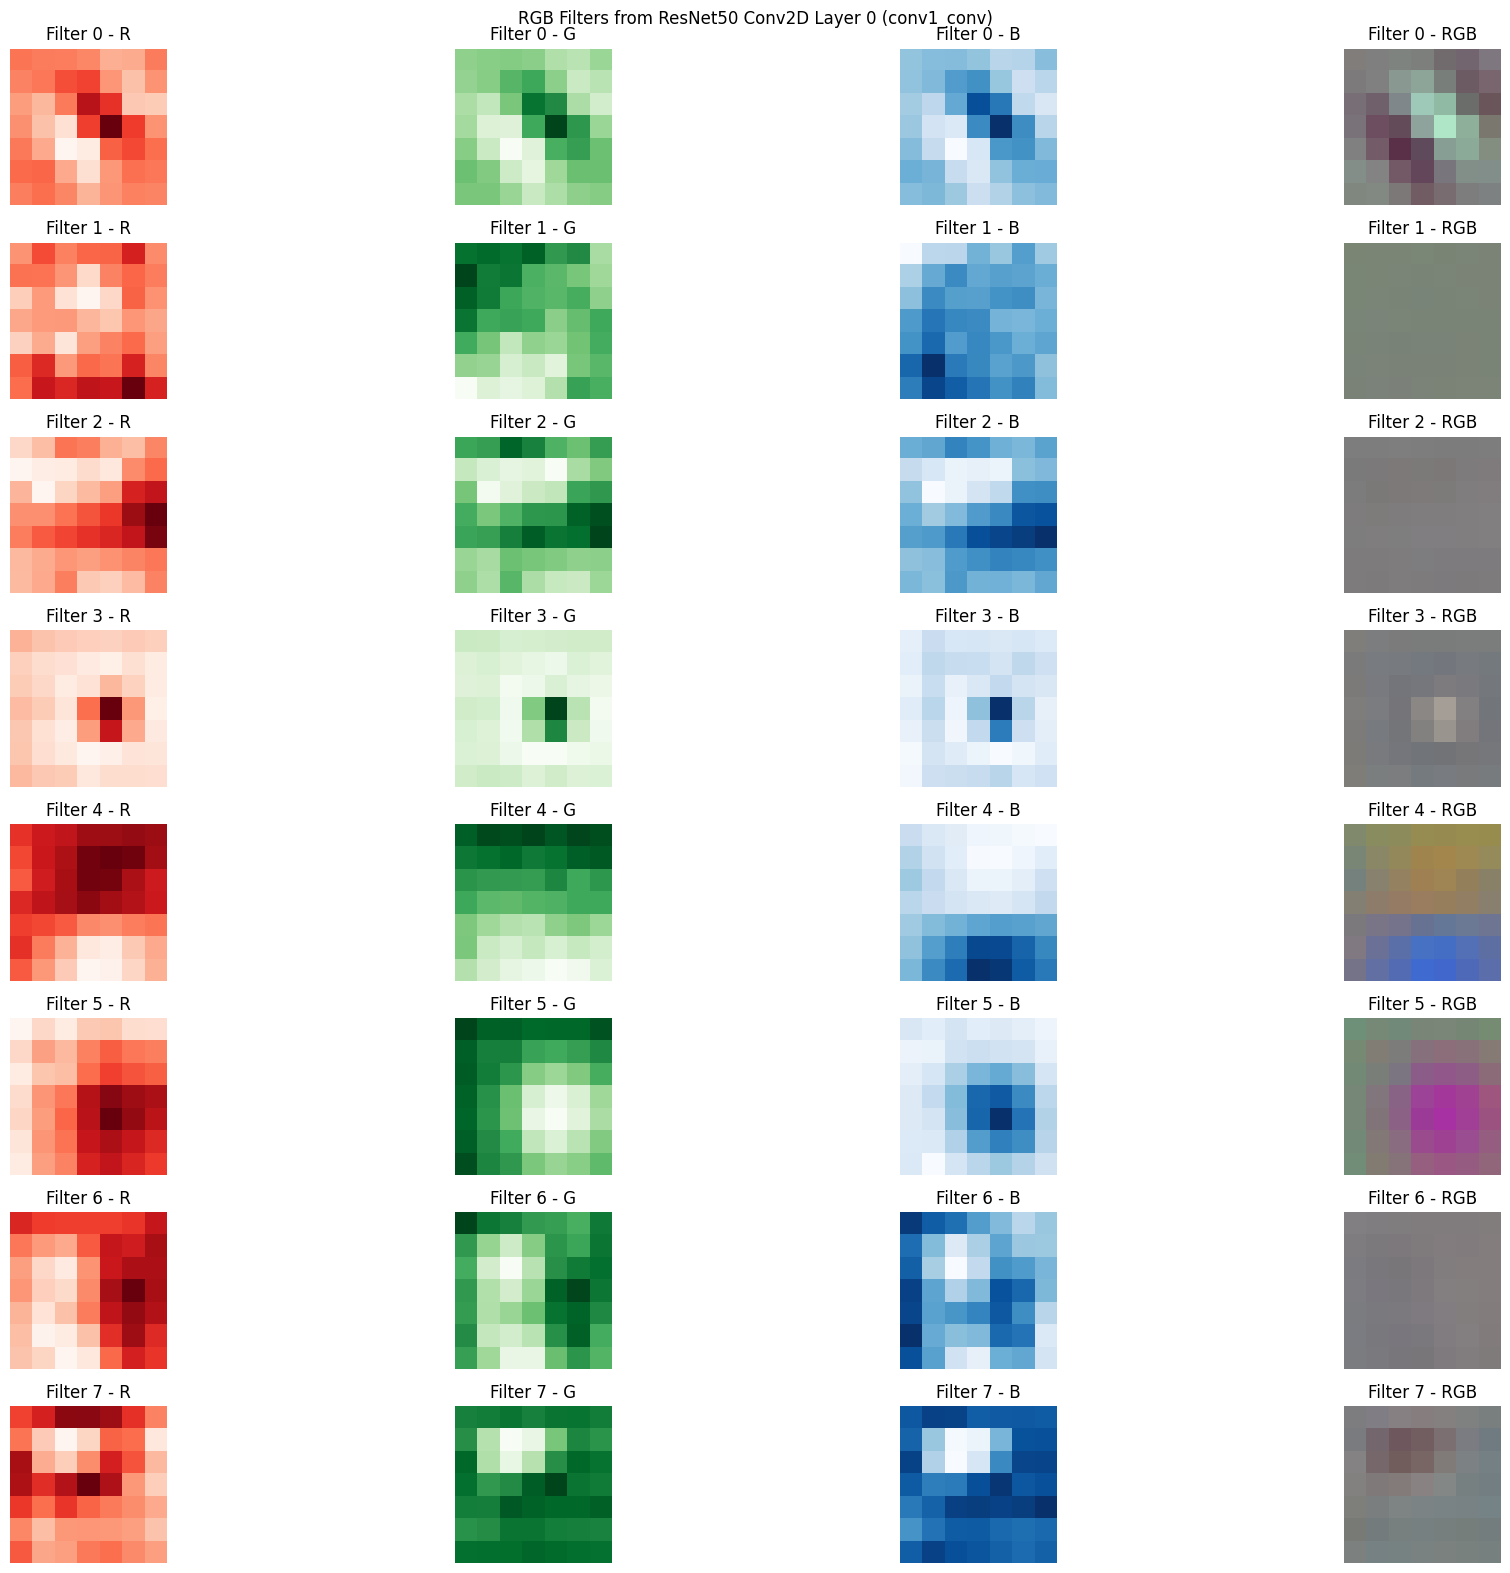

In [6]:
# Function to visualize filters by layer index from ResNet50
# --- Visualize RGB Filters ---
def visualize_rgb_filters(model, base_model, layer_index=0, num_filters=8):
    # Get all Conv2D layers from the base ResNet50 model
    conv_layers = [layer for layer in base_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

    if not conv_layers or layer_index >= len(conv_layers):
        print(f"Invalid layer index {layer_index}. Max index: {len(conv_layers)-1}")
        return

    # Get the specified Conv2D layer
    layer = conv_layers[layer_index]
    filters, biases = layer.get_weights()  # Shape: (height, width, input_channels, num_filters)
    print(f"Filters shape for layer {layer_index} ({layer.name}): {filters.shape}")

    # Ensure the layer has 3 input channels (RGB)
    if filters.shape[2] != 3:
        print(f"Layer {layer.name} does not have 3 input channels (RGB). Skipping RGB visualization.")
        return

    # Normalize filter values to [0, 1] for visualization
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # Plot RGB filters for the first few filters
    fig, axes = plt.subplots(num_filters, 4, figsize=(20, num_filters * 2))  # 4 columns: R, G, B, Combined
    for i in range(min(num_filters, filters.shape[-1])):
        # Extract the i-th filter (e.g., 7x7x3 for ResNet50's first layer)
        f = filters[:, :, :, i]  # Shape: (height, width, 3)

        # Separate R, G, B channels
        r_channel = f[:, :, 0]  # Red
        g_channel = f[:, :, 1]  # Green
        b_channel = f[:, :, 2]  # Blue

        # Combined RGB filter (stack channels for display)
        rgb_filter = np.stack([r_channel, g_channel, b_channel], axis=-1)

        # Plot each channel and the combined RGB
        axes[i, 0].imshow(r_channel, cmap='Reds')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Filter {i} - R')

        axes[i, 1].imshow(g_channel, cmap='Greens')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Filter {i} - G')

        axes[i, 2].imshow(b_channel, cmap='Blues')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f'Filter {i} - B')

        axes[i, 3].imshow(rgb_filter)
        axes[i, 3].axis('off')
        axes[i, 3].set_title(f'Filter {i} - RGB')

    plt.suptitle(f'RGB Filters from ResNet50 Conv2D Layer {layer_index} ({layer.name})')
    plt.tight_layout()
    plt.show()

# Visualize RGB filters from the first Conv2D layer (index 0)
visualize_rgb_filters(model, model.layers[0], layer_index=0, num_filters=8)